In [1]:
# -------------------------------------------
# CELL 1: SETUP & IMPORTS
# -------------------------------------------
# If you're setting up a fresh env, run in a terminal:
# pip install -U open_clip_torch chromadb pillow pymupdf torch torchvision

from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import os, io, re, json
import numpy as np

from PIL import Image            # Image I/O and manipulation
import fitz                      # PyMuPDF: PDF parsing / image extraction
import torch                     # Tensors + GPU compute
import open_clip                 # CLIP (text+image) embeddings
import chromadb                  # Vector DB for storing embeddings
from chromadb.config import Settings

# --- Basic project paths / names
PROJECT_ROOT = Path.cwd()
IMG_DIR = PROJECT_ROOT / "Nordberg HP300 Cone Crusher Manual/images"
PDF = PROJECT_ROOT / "Nordberg HP300 Cone Crusher Manual.pdf"                     # where PDFs + images live
PERSIST_DIR  = PROJECT_ROOT / "chroma_clip_mm"        # where Chroma saves its DB
COLLECTION_NAME = "multimodal_clip_unified"           # one collection for text+images

# --- CLIP model choice (text & image share the SAME space)
MODEL_NAME  = "ViT-B-32"
PRETRAINED  = "laion2b_s34b_b79k"    # 512-dim embeddings; great default for CLIP

# --- Hardware selection: use GPU if available, else CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Make sure directories exist
PERSIST_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Chroma dir: {PERSIST_DIR.resolve()}")

c:\Users\Alejandro\OneDrive\code\Win-LuckyRAG\lucky_win\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Chroma dir: C:\Users\Alejandro\OneDrive\code\Win-LuckyRAG\chroma_clip_mm


In [2]:
# -------------------------------------------
# CELL 2: LangChain + OpenCLIP + Chroma wiring
# -------------------------------------------

# If needed, install:
# pip install -U langchain langchain-community langchain-experimental langchain-chroma chromadb open-clip-torch

from pathlib import Path
from typing import List
import numpy as np

# LangChain core & integrations
from langchain_experimental.open_clip.open_clip import OpenCLIPEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# ---- Configuration (reuse from Cell 1 or redefine here)
PERSIST_DIR = Path("chroma_clip_mm")      # on-disk DB for embeddings
COLLECTION_NAME = "multimodal_clip_unified"

# ---- 1) Create an OpenCLIP embeddings object (text + image space)
clip_embedder = OpenCLIPEmbeddings(
    model_name="ViT-B-32",               # CLIP vision encoder backbone
    checkpoint="laion2b_s34b_b79k"       # pretrained weights (shared text/image space)
)

# ---- 2) Initialize a Chroma vector store that uses our CLIP embedder
# We'll start with an empty store. We can add text docs now, images later.
vectorstore = Chroma(
    collection_name=COLLECTION_NAME,
    persist_directory=str(PERSIST_DIR),
    embedding_function=clip_embedder
)

print("Vector store ready:", vectorstore)

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_96744\588655291.py:29: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


Vector store ready: <langchain_community.vectorstores.chroma.Chroma object at 0x00000299B9D9E7D0>


In [4]:
# -------------------------------------------
# CELL 3: TEXT INGESTION UTILITIES
# -------------------------------------------

from pathlib import Path
from typing import List, Dict, Optional
import re

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Reuse the vectorstore from Cell 2: `vectorstore`

def normalize_ws(text: str) -> str:
    """
    Collapse runs of whitespace and strip leading/trailing spaces.
    Keeps content stable for embedding & deduping.
    """
    return re.sub(r"\s+", " ", text).strip()

def make_text_splitter(chunk_size: int = 800, chunk_overlap: int = 120) -> RecursiveCharacterTextSplitter:
    """
    Recommended splitter for manuals / long PDFs.
    Overlap ensures context continuity across chunk boundaries.
    """
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        add_start_index=True,  # stores start_index for each chunk in metadata
    )

def strings_to_documents(
    strings: List[str],
    source_id: str,
    extra_meta: Optional[Dict] = None
) -> List[Document]:
    """
    Convert raw strings to LangChain Documents with strong metadata.
    `source_id` should be a stable identifier (e.g., PDF filename).
    """
    docs: List[Document] = []
    for i, s in enumerate(strings):
        content = normalize_ws(s)
        if not content:
            continue
        meta = {"source": source_id, "chunk_index": i}
        if extra_meta:
            meta.update(extra_meta)
        docs.append(Document(page_content=content, metadata=meta))
    return docs

def add_texts_to_chroma(
    texts: List[str],
    source_id: str,
    extra_meta: Optional[Dict] = None,
    chunk_size: int = 800,
    chunk_overlap: int = 120,
) -> List[str]:
    """
    Split, wrap as Documents, and add to the Chroma vectorstore.
    Returns the list of inserted IDs.
    """
    splitter = make_text_splitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    # Split in-memory strings into chunked Documents
    chunks = splitter.create_documents(texts, metadatas=[{"source": source_id}] * len(texts))
    # Normalize whitespace and strengthen metadata
    docs = []
    for idx, d in enumerate(chunks):
        content = normalize_ws(d.page_content)
        meta = dict(d.metadata)
        meta.update({"chunk_index": idx, "modality": "text"})
        docs.append(Document(page_content=content, metadata=meta))

    # Add to Chroma using the CLIP embedder (text path of OpenCLIP)
    ids = vectorstore.add_documents(docs)
    vectorstore.persist()  # flush to disk
    return ids

# Smoke Test - Ignore

In [3]:
# sample_paras = [
#     "Lock out all energy sources before performing maintenance on the HP300.",
#     "Use a calibrated torque wrench when tightening the bowl clamping bolts to 80 Nm."
# ]
# ids = add_texts_to_chroma(sample_paras, source_id="hp300_manual_excerpt")
# print(f"Inserted {len(ids)} text chunks. Example ID: {ids[0]}")

NameError: name 'add_texts_to_chroma' is not defined

In [6]:
# -------------------------------------------
# CELL 4: PDF IMAGE EXTRACTION + IMAGE INGESTION
# -------------------------------------------
from __future__ import annotations
from pathlib import Path
from typing import Dict, List, Optional
import hashlib
import os

import fitz  # PyMuPDF
from langchain_community.vectorstores import Chroma  # reuse the instance created earlier

# Reuse: `vectorstore` from Cell 2 (must be initialized with OpenCLIPEmbeddings)


def _sha256(data: bytes) -> str:
    """
    Stable hash for de-duplication. If two extracted images have the same bytes,
    this returns the same 64-hex digest.
    """
    return hashlib.sha256(data).hexdigest()


def extract_images_from_pdf(
    pdf_path: Path,
    out_dir: Path,
    min_dim: int = 64,
    min_area: int = 4096,
    dedupe: bool = True,
) -> List[Dict]:
    """
    Extract raster images embedded in a PDF using PyMuPDF and save to disk.

    Returns a list of dicts with:
      - file_path (Path)
      - page (int, 1-based)
      - xref (int, the PDF image cross-ref id)
      - width, height (int)
      - ext (str)  # e.g., 'png' or 'jpeg'
      - sha256 (str)
      - source (str)  # pdf filename
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    results: List[Dict] = []
    seen_hashes = set()

    with fitz.open(str(pdf_path)) as doc:
        for page_index, page in enumerate(doc, start=1):
            # page.get_images(full=True) lists images used on that page
            for img in page.get_images(full=True):
                xref = img[0]
                info = doc.extract_image(xref)  # bytes + metadata of that object
                if not info or "image" not in info:
                    continue

                img_bytes = info["image"]
                ext = info.get("ext", "png")
                width = info.get("width", 0)
                height = info.get("height", 0)

                # Filter tiny / likely-noise images (icons, separators)
                if width < min_dim or height < min_dim or (width * height) < min_area:
                    continue

                digest = _sha256(img_bytes)
                if dedupe and digest in seen_hashes:
                    continue
                seen_hashes.add(digest)

                # Save with a stable, informative name
                stem = pdf_path.stem
                filename = f"{stem}_p{page_index}_xref{xref}_{width}x{height}.{ext}"
                file_path = out_dir / filename
                with open(file_path, "wb") as f:
                    f.write(img_bytes)

                results.append({
                    "file_path": file_path,
                    "page": page_index,
                    "xref": xref,
                    "width": width,
                    "height": height,
                    "ext": ext,
                    "sha256": digest,
                    "source": pdf_path.name,
                })

    return results


def add_images_to_chroma(
    images: List[Dict],
    modality_tag: str = "image"
) -> List[str]:
    """
    Add extracted images to the existing Chroma vector store using OpenCLIP.
    Uses Chroma's native `add_images` method, which calls the embedder's
    `embed_image()` under the hood.

    NOTE: For best results, ensure `vectorstore` was created with an
    OpenCLIPEmbeddings instance (from Cell 2).
    """
    if not images:
        return []

    uris = [str(x["file_path"]) for x in images]
    metadatas = []
    ids = []
    for x in images:
        # Create a readable, unique id that encodes provenance
        _id = f"{x['source']}#p{x['page']}-xref{x['xref']}-{x['sha256'][:8]}"
        ids.append(_id)
        meta = {
            "modality": modality_tag,
            "source": x["source"],
            "page": x["page"],
            "xref": x["xref"],
            "width": x["width"],
            "height": x["height"],
            "sha256": x["sha256"],
            "file_path": str(x["file_path"]),
        }
        metadatas.append(meta)

    # This calls OpenCLIPEmbeddings.embed_image() internally.
    inserted = vectorstore.add_images(uris=uris, metadatas=metadatas, ids=ids)
    # Chroma >=0.4 auto-persists; for older wrappers, you may still call persist()
    try:
        vectorstore.persist()
    except Exception:
        pass
    return inserted


def ingest_pdf_images(
    pdf_path: PDF,
    image_output_dir: IMG_DIR,
    min_dim: int = 64,
    min_area: int = 4096,
) -> List[str]:
    """
    Convenience wrapper: extract then index images from a PDF.
    """
    extracted = extract_images_from_pdf(
        pdf_path=pdf_path,
        out_dir=image_output_dir,
        min_dim=min_dim,
        min_area=min_area,
    )
    return add_images_to_chroma(extracted)

In [7]:
from pathlib import Path

                

added_ids = ingest_pdf_images(
    pdf_path=Path("Data/Nordberg HP300 Cone Crusher Manual.pdf"),
    image_output_dir=Path("IMGs/Nordberg HP300 Cone Crusher Manual/images"),
    min_dim=96,          # ignore tiny icons
    min_area=12_000      # ignore small separators
)
print(f"Indexed {len(added_ids)} images")


Indexed 121 images


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_96744\3301867827.py:129: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [8]:
# -------------------------------------------
# CELL 5: RETRIEVERS + DEMOS
# -------------------------------------------
from __future__ import annotations
from typing import List, Dict, Optional, Tuple
from pathlib import Path
import math
import pprint

# We reuse the Chroma `vectorstore` from earlier cells.

pp = pprint.PrettyPrinter(indent=2, width=120)


def pretty(rows: List[Dict], header: str = "Results"):
    """Compact printer for retrieval results."""
    print(f"\n=== {header} (top {len(rows)}) ===")
    for i, r in enumerate(rows, 1):
        meta = r.get("metadata", {})
        score = r.get("score")  # Some wrappers include distance or score
        label = meta.get("modality", "text")
        src = meta.get("source", "—")
        page = meta.get("page", "—")
        path = meta.get("file_path", "")
        snippet = r.get("page_content", "")[:160].replace("\n", " ")
        print(f"{i:>2}. [{label}] score={score} source={src} page={page}")
        if label == "image" and path:
            print(f"    image: {path}")
        if snippet:
            print(f"    text : {snippet}{'...' if len(r.get('page_content', ''))>160 else ''}")


# -- Core: TEXT search (optionally filter by modality) ----------------------

def search_by_text(
    query: str,
    k: int = 5,
    modality: Optional[str] = None,
    where: Optional[Dict] = None,
) -> List[Dict]:
    """
    Query the unified space using a text query.
    - modality=None → search across everything (text+image).
    - modality='text' or 'image' → filter to that modality only.
    - `where` lets you pass raw Chroma metadata filters (dict).
    Returns list of dicts: {page_content, metadata, score, ...}
    """
    # Build metadata filter
    where_filter = dict(where) if where else {}
    if modality in {"text", "image"}:
        where_filter["modality"] = modality

    # LangChain's `similarity_search_with_relevance_scores` returns (Document, score)
    hits = vectorstore.similarity_search_with_relevance_scores(
        query=query,
        k=k,
        filter=where_filter if where_filter else None,
    )

    # Normalize to dicts for consistent printing / downstream use
    results = []
    for doc, score in hits:
        results.append({
            "page_content": doc.page_content,
            "metadata": doc.metadata,
            "score": score,
        })
    return results


# -- Core: IMAGE search (optionally filter by modality) --------------------

def search_by_image(
    image_path: Path,
    k: int = 5,
    modality: Optional[str] = None,
    where: Optional[Dict] = None,
) -> List[Dict]:
    """
    Query the unified space using an image file (path).
    - modality=None → search across everything.
    - modality='text' or 'image' → filter results.
    """
    where_filter = dict(where) if where else {}
    if modality in {"text", "image"}:
        where_filter["modality"] = modality

    # LangChain-Chroma exposes image search via `similarity_search_by_image`
    hits = vectorstore.similarity_search_by_image(
        uri=str(image_path),
        k=k,
        filter=where_filter if where_filter else None,
    )

    # Some wrappers return just Documents; we compute a pseudo-score placeholder
    results = []
    for idx, doc in enumerate(hits):
        results.append({
            "page_content": doc.page_content,
            "metadata": doc.metadata,
            "score": None,  # not all versions return a numeric score
        })
    return results


# -- Hybrid: fuse text + image (Reciprocal Rank Fusion) --------------------

def rrf_fuse(
    lists: List[List[Dict]],
    k: int = 10,
    kappa: int = 60,
    id_key: str = "doc_id"
) -> List[Dict]:
    """
    Reciprocal Rank Fusion:
    score(doc) = sum( 1 / (kappa + rank_i(doc)) ) over input lists.
    Assumes each dict has a unique, stable identifier in metadata or we derive one.

    We return top-k unique rows with combined scores, preserving a representative payload.
    """
    # Make per-result IDs (fall back to file path, or hash of content+source)
    def derive_id(d: Dict) -> str:
        meta = d.get("metadata", {})
        # prefer our stable IDs if present
        for key in ("id", "doc_id", "source_id"):
            if key in meta:
                return str(meta[key])
        # fallbacks
        if "file_path" in meta:
            return f"fp:{meta['file_path']}"
        src = meta.get("source", "")
        page = meta.get("page", "")
        return f"src:{src}#p{page}|{hash(d.get('page_content',''))}"

    # Build rank maps
    score_map = {}
    payload_map = {}
    for L in lists:
        for rank, d in enumerate(L, 1):  # 1-based
            did = derive_id(d)
            score_map.setdefault(did, 0.0)
            score_map[did] += 1.0 / (kappa + rank)
            # Keep the best representative payload (first occurrence wins)
            payload_map.setdefault(did, d)

    # Sort by fused score desc
    fused = sorted(score_map.items(), key=lambda kv: kv[1], reverse=True)
    out = []
    for did, s in fused[:k]:
        d = dict(payload_map[did])
        d["rrf_score"] = s
        out.append(d)
    return out


def hybrid_text_search(
    query: str,
    k_each: int = 5,
    final_k: int = 8
) -> List[Dict]:
    """
    1) Run text→image-only and text→text-only in parallel.
    2) Fuse with RRF.
    """
    text_hits  = search_by_text(query, k=k_each, modality="text")
    image_hits = search_by_text(query, k=k_each, modality="image")
    fused = rrf_fuse([text_hits, image_hits], k=final_k)
    return fused


def hybrid_image_search(
    image_path: Path,
    k_each: int = 5,
    final_k: int = 8
) -> List[Dict]:
    """
    1) Run image→image-only and image→text-only.
    2) Fuse with RRF.
    """
    image_hits = search_by_image(image_path, k=k_each, modality="image")
    text_hits  = search_by_image(image_path, k=k_each, modality="text")
    fused = rrf_fuse([image_hits, text_hits], k=final_k)
    return fused


# -- Convenience: "what does X look like?" ---------------------------------

def what_does_it_look_like(
    query: str,
    k_images: int = 6
) -> List[Dict]:
    """
    Given a text query, pull back the most likely matching **images**.
    (We can show text neighbors alongside, but first this focuses on diagrams.)
    """
    return search_by_text(query, k=k_images, modality="image")


# -- Tiny demos -------------------------------------------------------------

def demo_text_query(query: str):
    print(f"\n>>> TEXT QUERY: {query!r}")
    # Search across both modalities
    mixed = search_by_text(query, k=6, modality=None)
    pretty(mixed, header="Mixed (text+image) by text query")

    # “What does it look like?”
    looks = what_does_it_look_like(query, k_images=6)
    pretty(looks, header="Images only")

    # Hybrid fusion (text-only vs image-only)
    fused = hybrid_text_search(query, k_each=5, final_k=8)
    pretty(fused, header="Hybrid (RRF fused)")


def demo_image_query(image_path: Path):
    print(f"\n>>> IMAGE QUERY: {image_path}")
    # Search across both modalities
    mixed = search_by_image(image_path, k=6, modality=None)
    pretty(mixed, header="Mixed (text+image) by image query")

    # Hybrid (image-only vs text-only)
    fused = hybrid_image_search(image_path, k_each=5, final_k=8)
    pretty(fused, header="Hybrid (RRF fused)")

In [9]:
# -------------------------------------------
# CELL 6: COMPACT RAG CHAIN
# -------------------------------------------
from __future__ import annotations
from typing import List, Dict, Any, Optional
from pathlib import Path
import dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
import os

openai_api_key = dotenv.get_key(".env", "OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("OPENAI_API_KEY not found in .env file.")
os.environ["OPENAI_API_KEY"] = openai_api_key  # adjust as needed
# --- Config knobs
TOP_K_TEXT   = 6
TOP_K_IMAGES = 6
SCORE_THRESH = 0.3   # ignore very weak text matches (0..1 relevance scale)

# Reuse the existing `vectorstore` from earlier cells
retriever = vectorstore.as_retriever(
    search_kwargs={
        "k": TOP_K_TEXT,
        # You can also pass a metadata filter here, e.g. {"source": {"$eq": "Nordberg_HP300.pdf"}}
    }
)

def build_context_and_diagrams(docs):
    """
    Input: list of {'doc': Document, 'score': Optional[float]}
    Output:
      - context: compact text for LLM with inline [source p.X] citations
      - diagrams: list of {'file_path','source','page','score'} for UI
    """
    text_lines, diagram_list = [], []

    for d in docs:
        doc  = d["doc"]
        meta = doc.metadata or {}
        score = d.get("score", None)
        mod  = meta.get("modality", "text")
        src  = meta.get("source", "unknown")
        page = meta.get("page", "—")

        if mod == "image":
            fp = meta.get("file_path", "")
            diagram_list.append({
                "file_path": fp,
                "source": src,
                "page": page,
                "score": score,
            })
        else:
            snippet = doc.page_content.strip().replace("\n", " ")
            tag = f"[{src} p.{page}]"
            if score is not None:
                tag += f" (rel={score:.2f})"
            text_lines.append(f"- {tag} {snippet}")

    context = []
    if text_lines:
        context.append("TEXT EXCERPTS:\n" + "\n".join(text_lines))
    # We do NOT inline images into the LLM context; we hand them to the UI
    return {
        "context": "\n\n".join(context) if context else "No textual context retrieved.",
        "diagrams": diagram_list
    }

# Stage that takes {"question": "..."} and returns {"question", "context", "diagrams"}
prep_for_llm = RunnableLambda(
    lambda x: {
        "question": x["question"],
        **build_context_and_diagrams(
            retrieve(x["question"])["hits"]  # list of {'doc', 'score'}
        ),
    }
)


def retrieve(query: str) -> Dict[str, Any]:
    """
    1) text→mixed retrieval (top text hits with scores)
    2) images-only retrieval for visuals
    3) merge + dedupe; keep scores when available
    """
    # Text side with relevance scores (0..1)
    text_hits = vectorstore.similarity_search_with_relevance_scores(query, k=TOP_K_TEXT)
    text_payload = [{"doc": d, "score": s} for d, s in text_hits if s >= SCORE_THRESH]

    # Image side by text query: filter=modality:image
    image_docs = vectorstore.similarity_search(query, k=TOP_K_IMAGES, filter={"modality": "image"})
    image_payload = [{"doc": d, "score": None} for d in image_docs]

    # Merge + dedupe by an identifier (prefer file_path or (source,page))
    seen = set()
    merged = []
    def doc_id(x):
        m = x["doc"].metadata or {}
        return m.get("file_path") or f"{m.get('source','')}#p{m.get('page','')}"
    for x in text_payload + image_payload:
        key = doc_id(x)
        if key in seen:
            continue
        seen.add(key)
        merged.append(x)
    return {"query": query, "hits": merged}

# --- Prompt (mechanic-friendly, safety-first)
SYSTEM_PROMPT = """You are a senior aggregates plant mechanic assistant.
Write step-by-step, safe procedures grounded ONLY in the provided context.
If the context is insufficient, say so and ask for a specific follow-up.
Prefer precise terms, torque values, and cautions from the context.
Cite sources inline as [source p.X]. Do not invent steps or numbers."""

USER_PROMPT = """Question:
{question}

Context (retrieved):
{context}

Instructions:
1) Output numbered steps and concise cautions grounded in the context.
2) Add a final section titled "Related diagrams" that lists the filenames we provided (do not invent new ones).
3) If a step depends on a diagram, reference it by filename.
"""

prompt = ChatPromptTemplate.from_messages([("system", SYSTEM_PROMPT), ("user", USER_PROMPT)])
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Build a branched output:
# - "answer": goes through the LLM,
# - "diagrams": passed through directly for the UI to render.
rag_chain = (
    prep_for_llm
    | {
        "answer": (prompt | llm | StrOutputParser()),
        "diagrams": RunnableLambda(lambda x: x["diagrams"]),
      }
)



In [10]:
res = rag_chain.invoke({"question": "Lockout-Tagout for HP300 accumulator replacement"})
print(
    res["answer"],  # grounded steps + citations
    res["diagrams"])
# Render top image hits (paths) in your notebook UI:
for i, d in enumerate(res["diagrams"][:6], 1):
    print(f"{i}. {d['file_path']}  (src={d['source']}, p.{d['page']}, score={d['score']})")


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_96744\2239941457.py:91: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'chunk_index': 0, 'source': 'hp300_manual_excerpt', 'start_index': 0, 'modality': 'text'}, page_content='Lock out all energy sources before performing maintenance on the HP300.'), 0.48832491005113277), (Document(metadata={'source': 'hp300_manual_excerpt', 'chunk_index': 1, 'modality': 'text', 'start_index': 0}, page_content='Use a calibrated torque wrench when tightening the bowl clamping bolts to 80 Nm.'), 0.4163134790349954), (Document(metadata={'file_path': 'IMGs\\Nordberg HP300 Cone Crusher Manual\\images\\Nordberg HP300 Cone Crusher Manual_p245_xref710_852x712.jpeg', 'page': 245, 'xref': 710, 'width': 852, 'sha256': '69859cfc616db70d37e66e63a724fae1159f84502cf854d354c744d0e625924d', 'height': 712, 'modality': 'image', 'source': 'Nordberg HP300 Cone Crusher Manual.pdf'}, page_content='/9j/4gxYSUNDX1BST0ZJTEUAAQEAAAxITGlubwIQAABtbnRy

### Lockout-Tagout for HP300 Accumulator Replacement

1. **Identify Energy Sources**: Before beginning any maintenance, identify all energy sources connected to the HP300.

2. **Lock Out Energy Sources**: Use appropriate lockout devices to lock out all identified energy sources to ensure they cannot be accidentally re-energized during maintenance.

3. **Tag Out Energy Sources**: Place warning tags on all locked-out energy sources to inform others that maintenance is being performed and that the equipment should not be operated.

4. **Verify Isolation**: After locking and tagging out, verify that all energy sources are effectively isolated. This may include checking for residual pressure in the system.

5. **Perform Maintenance**: Once isolation is confirmed, proceed with the replacement of the accumulator as per the manufacturer's guidelines.

6. **Remove Lockout-Tagout Devices**: After completing the maintenance and ensuring that the area is clear of tools and personnel, remove the lo

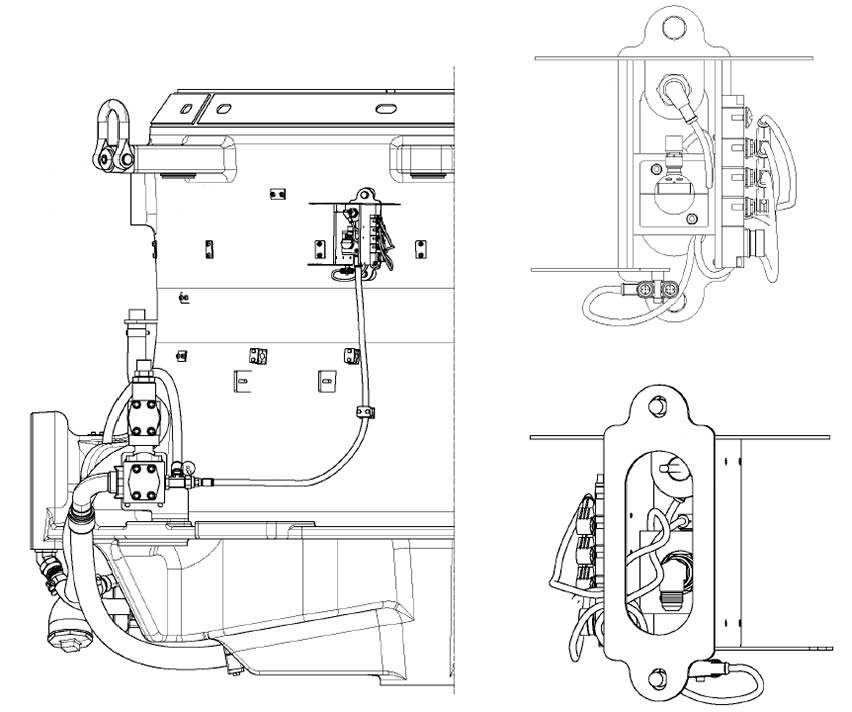

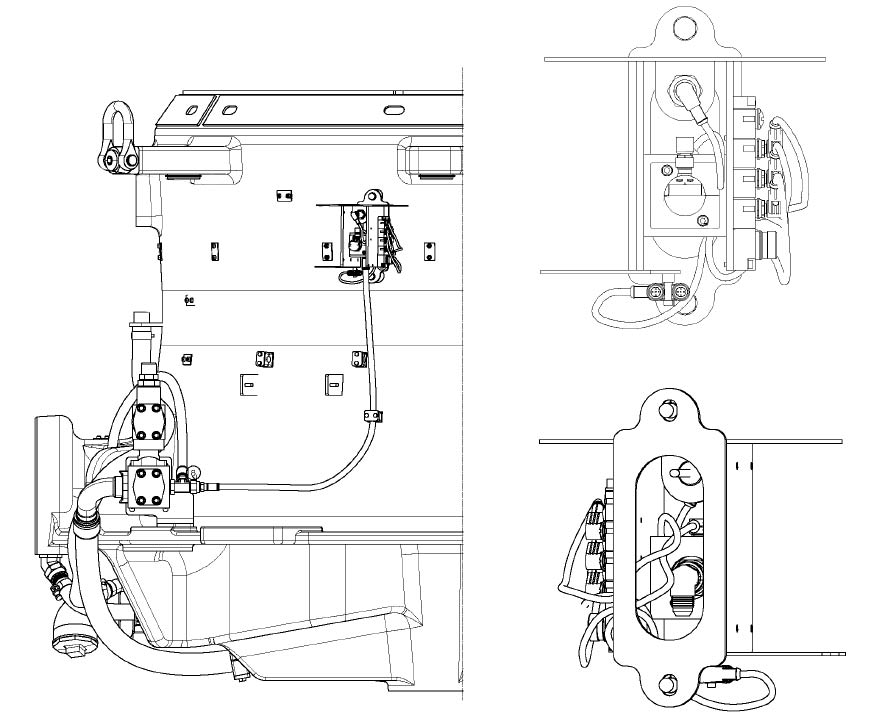

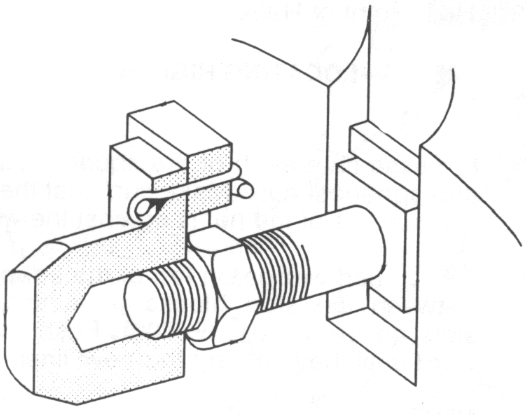

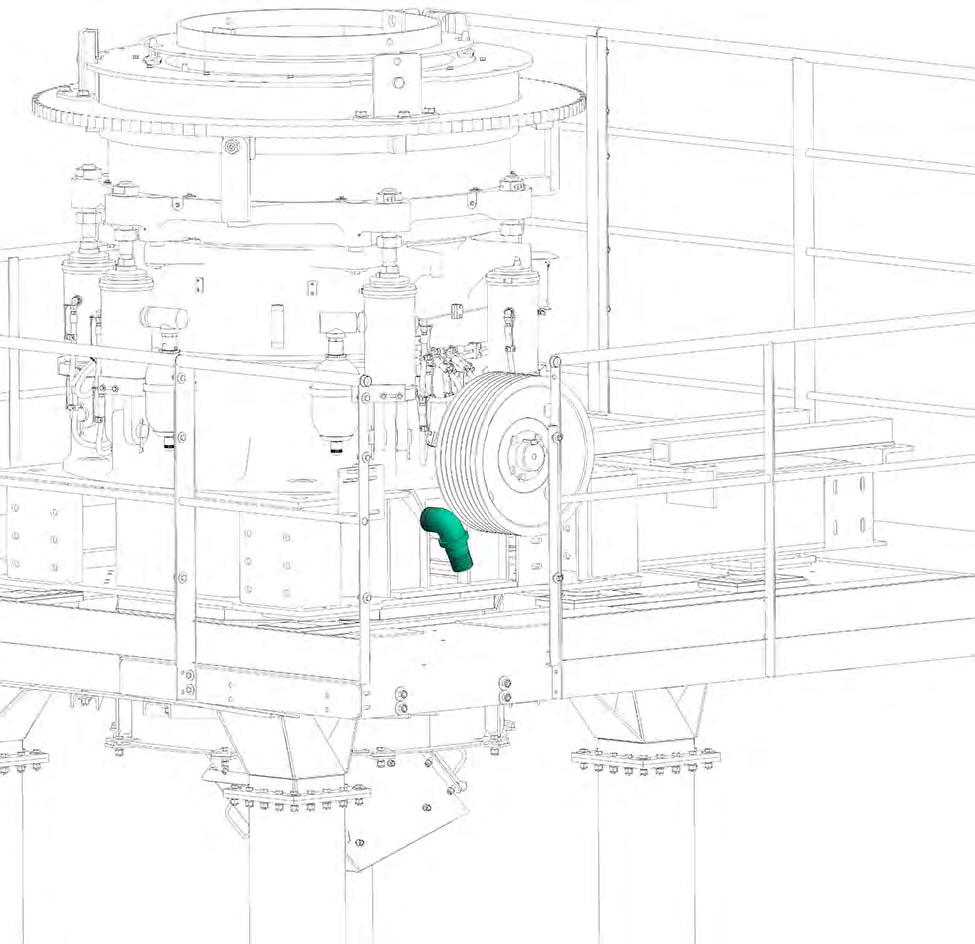

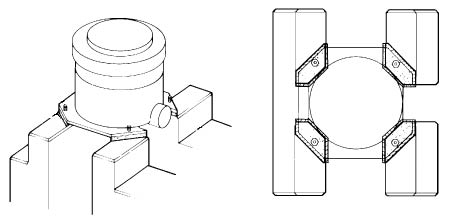

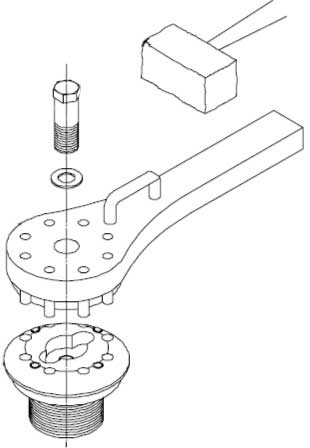

In [11]:
from IPython.display import display, Image as IPyImage

def show_diagrams(diagrams, max_n=6):
    for d in diagrams[:max_n]:
        if d["file_path"]:
            display(IPyImage(filename=d["file_path"], width=480))

show_diagrams(res["diagrams"])


In [ ]:
imgs = vectorstore.similarity_search("accumulator", k=3, filter={"modality":"image"})
[d.metadata.get("file_path") for d in imgs]


['IMGs\\Nordberg HP300 Cone Crusher Manual\\images\\Nordberg HP300 Cone Crusher Manual_p114_xref321_731x900.png',
 'IMGs\\Nordberg HP300 Cone Crusher Manual\\images\\Nordberg HP300 Cone Crusher Manual_p215_xref773_822x867.png',
 'IMGs\\Nordberg HP300 Cone Crusher Manual\\images\\Nordberg HP300 Cone Crusher Manual_p223_xref777_615x928.png']